### Personal Details
Name : Brenda Chepkoech

Student ID: 10629571

Email : 10629571@mydbs.ie

Program : MSc AI

Module Name: Deep Learning

## Univariate vs. Multivariate Time Series Prediction using LSTM

LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) that is widely used for time series prediction tasks. LSTM networks are well-suited for capturing long-term dependencies in sequential data, making them effective for modeling time series data.

## Load the libraries

In [1]:
#Import the Libraries
from pandas_datareader import data as web #allows you to  download financial data from online sources
import math # Mathematical functions
import numpy as np # for working with arrays
import pandas as pd #  for analysing and manipulating data
from datetime import date, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # adds plotting functions for calender dates
import matplotlib.pyplot as plt # for visualization
import matplotlib.dates as mdates # Formatting dates
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data
import seaborn as sns # Visualization
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
plt.style.use('fivethirtyeight')
import os

# Importing the Keras Libraries and packages
import tensorflow as tf
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
#from keras.callbacks import EarlyStopping # EarlyStopping during model training technique to prevent overfitting and improve the efficiency of model training

# Getting Apple Inc quotes
stockname = 'Apple Inc'
symbol = 'AAPL'

## Load the Data

In [ ]:
!pip install yfinance

In [2]:
import yfinance as fyf
fyf.pdr_override() # <-- Here is the fix

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


In [3]:
#importing data from jan 2014 to june 2023
start_date = datetime(2014,1,1)
end_date = datetime(2024,6,20) #june

In [4]:
#Get the stock quote
df = web.DataReader('AAPL', start = start_date, end = end_date) # Apple Inc stock price
df.to_excel('apple_stock_price.xlsx')
df2 = df.copy()
#Show the data
df.head(5)


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.845715,19.893929,19.715000,19.754642,17.296659,234684800
2014-01-03,19.745001,19.775000,19.301071,19.320715,16.916729,392467600
2014-01-06,19.194643,19.528570,19.057142,19.426071,17.008963,412610800
2014-01-07,19.440001,19.498571,19.211430,19.287144,16.887327,317209200
2014-01-08,19.243214,19.484285,19.238930,19.409286,16.994272,258529600


In [5]:
# Get the number of rows and columns of the dataset
df.shape

(2631, 6)

## Exploring the Data

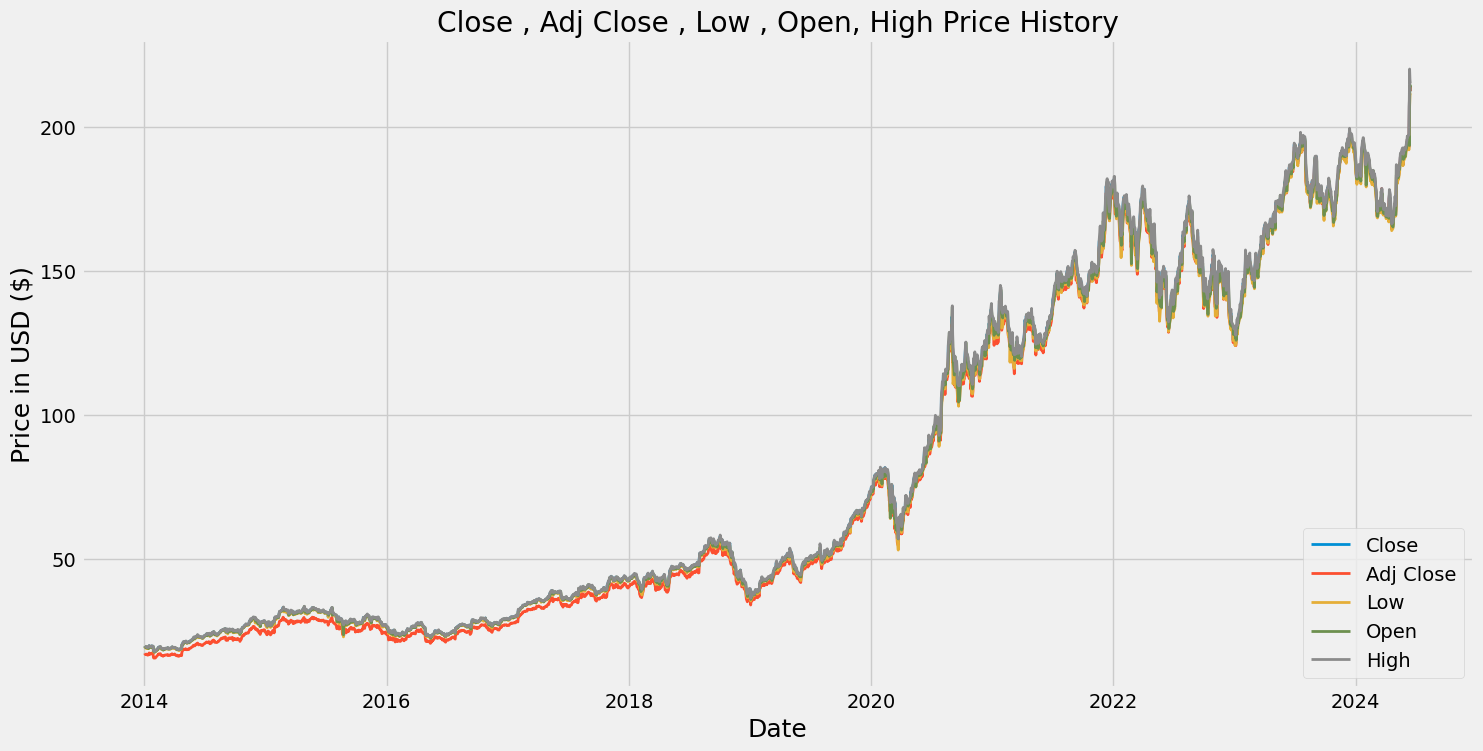

In [6]:
# Visualize the aple price history
plt.figure(figsize=(16,8))
plt.title('Close , Adj Close , Low , Open, High Price History')
plt.plot(df[['Close','Adj Close','Low' , 'Open', 'High']],linewidth=2.0)
plt.legend(['Close','Adj Close','Low' , 'Open', 'High'],loc ='lower right')
plt.xlabel('Date',fontsize = 18)
plt.ylabel('Price in USD ($)',fontsize=18)
plt.show()

# Univariate Stock Market Prediction

## Data Preparation

In [7]:
# Feature Selection - Only Close Data
train_df = df.filter(['Close'])
data_unscaled = train_df.values

# Get the number of rows to train the model on 80% of the data
train_data_length = math.ceil(len(data_unscaled) * 0.8)

# Transform features by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
np_data = scaler.fit_transform(data_unscaled)

## Creating the Input Shape

So we make multiple slices of the training data (x_train), so-called mini-batches. The neural network processes the mini-batch one by one during the training process and creates a separate forecast for each mini-batch. The illustration below shows the shape of the data:

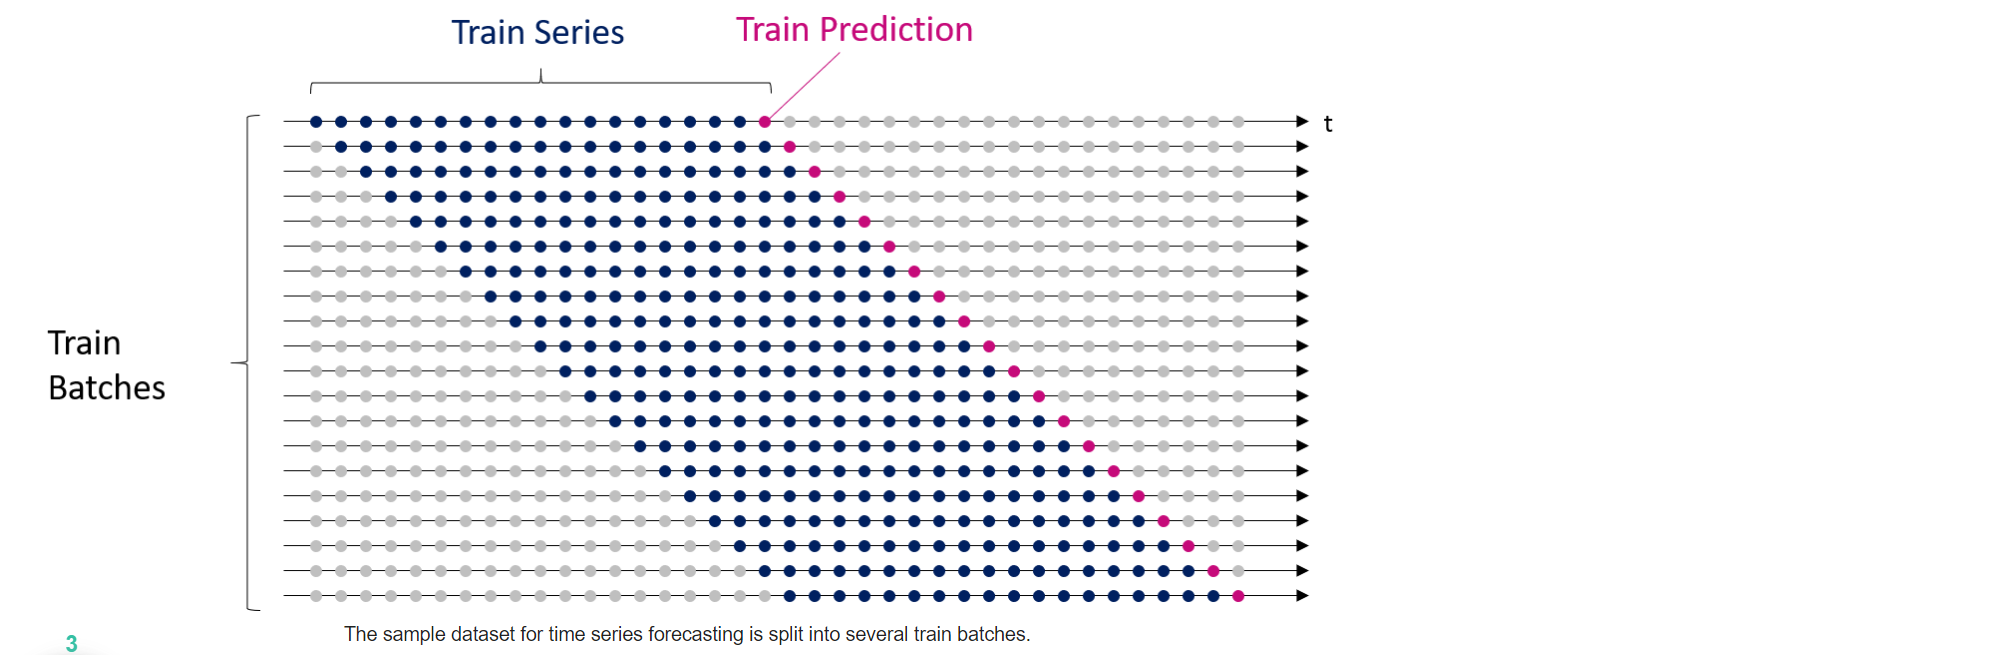

Neural networks learn in an iterative process. The algorithm reduces the prediction errors by adjusting the connection strength between the neurons (weights) in this process. The model needs a second list (y_train) to evaluate the forecast quality, containing the valid price values from our ground truth. The model compares the predictions with the ground truth during training and calculates the training error to minimize it over time.

In [8]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 60 # we predict the price of the next day based on the last 60 days of market prices

# Prediction Index
index_Close = train_df.columns.get_loc("Close") #  index (integer location) of the column  "Close"
print(index_Close)

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data
train_data_len = math.ceil(np_data.shape[0] * 0.8)

# Create the training and test data
train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, train_df):
    x, y = [], []
    data_len = train_df.shape[0]
    for i in range(sequence_length, data_len):
        x.append(train_df[i-sequence_length:i,:])# it appends a sequence of the 60 previous data points (from i-60 to i) to the x_train list
        y.append(train_df[i, index_Close]) # it appends the next data point (the 61st day value) to the y_train list.

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_test[1][sequence_length-1][index_Close])
print(y_test[0])

0
(2045, 60, 1) (2045,)
(526, 60, 1) (526,)
0.6350132643718469
0.6350132643718469


## Designing the Model

In [ ]:
# Initializing the RNN
model =  Sequential()

In [ ]:
# Add first 50 nodes LSTM layer. Make return_sequence is true because we are adding more LSTM layers.
# return_sequence is true indicates that the layer should return the full sequence of outputs rather than just the final output.
# Add dropout regularization to reduce the overfitting of the model.
model.add(LSTM(units = 60, return_sequences = True, input_shape =( x_train.shape[1],1)))
model.add(Dropout(0.2)) #drop 20% of the data

# Adding the second LSTM Layer and some dropout regularization
model.add(LSTM(units = 60, return_sequences = True))
model.add(Dropout(0.2))

# Adding Third LSTM Layer and some dropout regularization
model.add(LSTM(units = 60, return_sequences = True) )
model.add(Dropout(0.2))

# Adding forth LSTM Layer and some dropout regularization
model.add(LSTM(units = 60) )
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units= 1))
#and the last layer should have only one neuron, as the prediction will contain a single price point for a single time step

In [ ]:
model.summary()
#n_lstm_params = 4 * ((n_features * n_units) + n_units * n_units + n_units)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 60)            14880     
                                                                 
 dropout (Dropout)           (None, 60, 60)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            29040     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 60)            29040     
                                                                 
 dropout_2 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_3 (LSTM)               (None, 60)                2

In [ ]:
# Compiling the RNN
# Adam Optimizer to update the model's weights based on the computed gradients during the backpropagation.
# The loss is considered as mean squared error because we are dealing with continuous values.
model.compile(optimizer='adam', loss= 'mean_squared_error')

## Train the Univariate Model

In [ ]:
# Fitting the RNN to the training DataSet.
model.fit(x_train, y_train, epochs = 25, batch_size = 32)

Epoch 1/25
58/58 [==============================] - 34s 300ms/step - loss: 0.0074
Epoch 2/25
58/58 [==============================] - 10s 165ms/step - loss: 0.0015
Epoch 3/25
58/58 [==============================] - 10s 164ms/step - loss: 0.0014
Epoch 4/25
58/58 [==============================] - 9s 148ms/step - loss: 0.0012
Epoch 5/25
58/58 [==============================] - 9s 158ms/step - loss: 0.0011
Epoch 6/25
58/58 [==============================] - 9s 163ms/step - loss: 9.7588e-04
Epoch 7/25
58/58 [==============================] - 9s 159ms/step - loss: 0.0012
Epoch 8/25
58/58 [==============================] - 8s 142ms/step - loss: 0.0011
Epoch 9/25
58/58 [==============================] - 9s 163ms/step - loss: 9.0970e-04
Epoch 10/25
58/58 [==============================] - 9s 163ms/step - loss: 0.0011
Epoch 11/25
58/58 [==============================] - 8s 144ms/step - loss: 9.2853e-04
Epoch 12/25
58/58 [==============================] - 13s 227ms/step - loss: 8.9151e-04
Epoch

## Make Predictions

In [ ]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

15/15 [==============================] - 2s 43ms/step


## Evaluate Model Performance


In [ ]:
# RMSE value
rmse = np.sqrt(np.mean(y_pred-y_test_unscaled)**2)
rmse

9.125119810344792

<Axes: title={'center': 'Predictions vs Ground Truth'}, xlabel='Date', ylabel='Apple Inc'>

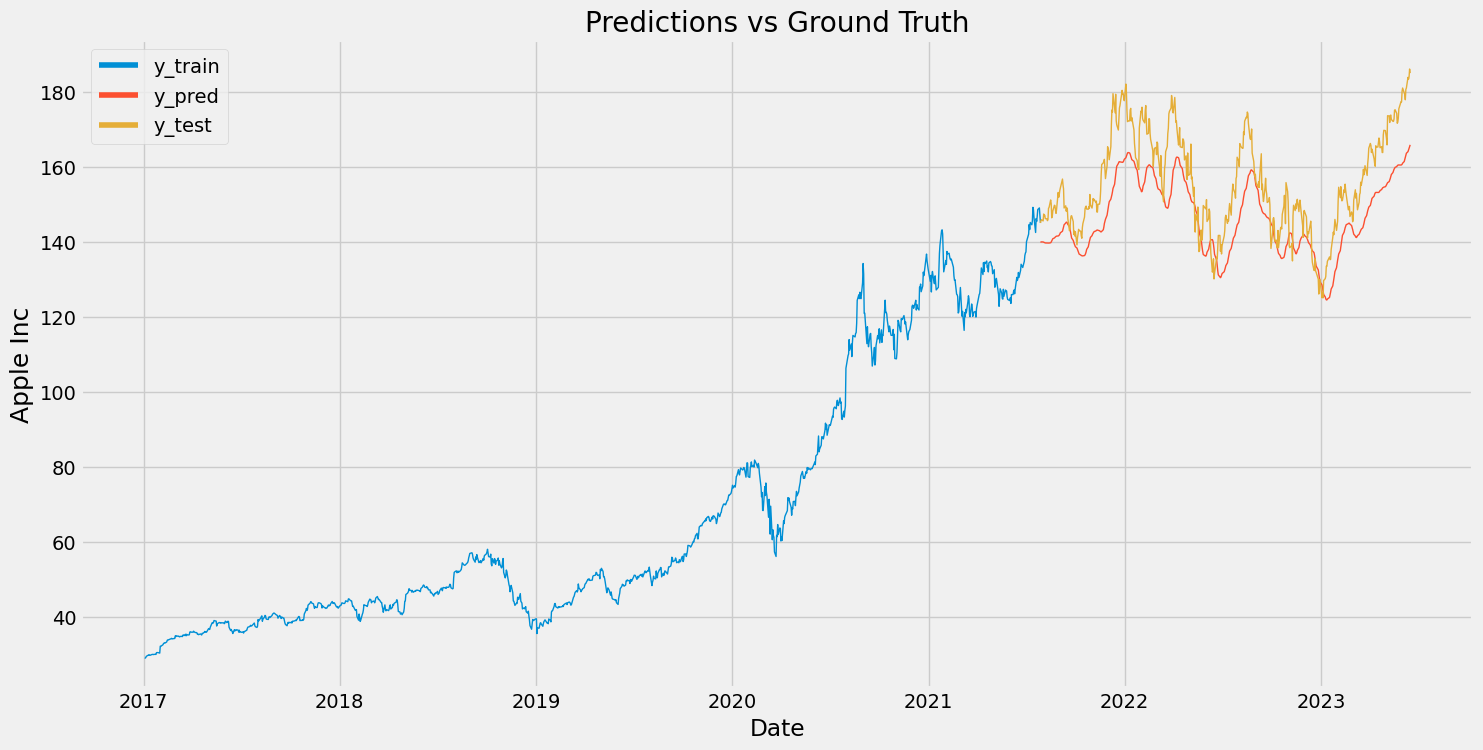

In [ ]:
# The date from which on the date is displayed
display_start_date = "2017-01-01"

# Add the difference between the valid and predicted prices
train = pd.DataFrame(train_df[:train_data_length + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(train_df[train_data_length:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8), sharex=True)
plt.title("Predictions vs Ground Truth")
#sns.set_palette(["#090364", "#1960EF", "#EF5919"])
plt.ylabel(stockname, fontsize=18)
sns.lineplot(data=df_union_zoom[['y_train', 'y_pred', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

## Predict the Next Day’s Price

In [ ]:
# Get fresh data
df_new = df.filter(['Close'])

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_days_scaled = scaler.transform(df_new[-60:].values)

# Create an empty list and Append past n days
X_test = []
X_test.append(last_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price, undo the scaling and output the predictions
pred_price = model.predict(X_test)
pred_price_unscaled = scaler.inverse_transform(pred_price)

# Print last price and predicted price for the next day
last_price = round(df_new['Close'][-1], 2)
predicted_price = round(pred_price_unscaled.ravel()[0], 2)
percent_change = round((predicted_price * 100)/last_price - 100, 2)

print('Last price was:', last_price)
print('predicted_price for next day is : ', predicted_price)
print('percent_change is : ', percent_change)


1/1 [==============================] - 0s 39ms/step
Last price was: 184.92
predicted_price for next day is :  166.32
percent_change is :  -10.06


In [ ]:
df_new.iloc[-1]

Close    184.919998
Name: 2023-06-16 00:00:00, dtype: float64

# Multivariate Time series Prediction

In [ ]:
df2.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.845715,19.893929,19.715000,19.754642,17.364960,234684800
2014-01-03,19.745001,19.775000,19.301071,19.320715,16.983521,392467600
2014-01-06,19.194643,19.528570,19.057142,19.426071,17.076138,412610800


## Feature Selection

In [ ]:
# creating a copy of dataset and sorting
#train_df = df2.copy()
train_df = df2.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume']

# Create the dataset with features needed and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
# The dummy column Predictions will help us later when we need to reverse the scaling of our data.
df3 = data_filtered.copy()
df3['Prediction'] = df3['Close']

# Print the tail of the dataframe
df3.head()

,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2014-01-02,19.893929,19.715000,19.845715,19.754642,234684800,19.754642
2014-01-03,19.775000,19.301071,19.745001,19.320715,392467600,19.320715
2014-01-06,19.528570,19.057142,19.194643,19.426071,412610800,19.426071
2014-01-07,19.498571,19.211430,19.440001,19.287144,317209200,19.287144
2014-01-08,19.484285,19.238930,19.243214,19.409286,258529600,19.409286


In [ ]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]
print(nrows)
# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

2381
(2381, 5)


# Scaling the dataset

In [ ]:
# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(df3['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

## Creating the input shape

In [ ]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 60

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(1845, 60, 5) (1845,)
(476, 60, 5) (476,)
0.00784964339786011
0.00784964339786011


## Train the Model

In [ ]:
#The number of neurons in the first layer must equal the size of a minibatch of the input data.
#Each minibatch in the dataset consists of a matrix with 60 steps and 5 features.
#Thus, the input layer of our recurrent neural network consists of 300 neurons.

In [ ]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(units = n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) # return theoutput so that you can stack another lstm layer
model.add(Dropout(0.2)) # droping 20% of the data

# Adding the second LSTM Layer and some dropout regularization
model.add(LSTM(units = n_neurons, return_sequences = True))
model.add(Dropout(0.2))

# Adding the third LSTM Layer and some dropout regularization
model.add(LSTM(units = n_neurons))
model.add(Dropout(0.2))

model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss= 'mean_squared_error')

300 60 5


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 300)           367200    
                                                                 
 dropout_4 (Dropout)         (None, 60, 300)           0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 300)           721200    
                                                                 
 dropout_5 (Dropout)         (None, 60, 300)           0         
                                                                 
 lstm_6 (LSTM)               (None, 300)               721200    
                                                                 
 dropout_6 (Dropout)         (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                

In [ ]:
# Fitting the RNN to the training DataSet.
#model.fit(x_train, y_train, epochs = 25, batch_size = 32)
model.fit(x_train, y_train, batch_size=32, epochs=25,validation_data=(x_test, y_test)
                   )

Epoch 1/25
58/58 [==============================] - 72s 1s/step - loss: 0.0035 - val_loss: 0.0017
Epoch 2/25
58/58 [==============================] - 64s 1s/step - loss: 6.8359e-04 - val_loss: 0.0013
Epoch 3/25
58/58 [==============================] - 63s 1s/step - loss: 5.8936e-04 - val_loss: 0.0123
Epoch 4/25
58/58 [==============================] - 63s 1s/step - loss: 5.2394e-04 - val_loss: 0.0017
Epoch 5/25
58/58 [==============================] - 63s 1s/step - loss: 4.8530e-04 - val_loss: 0.0026
Epoch 6/25
58/58 [==============================] - 63s 1s/step - loss: 5.6972e-04 - val_loss: 0.0022
Epoch 7/25
58/58 [==============================] - 63s 1s/step - loss: 5.8787e-04 - val_loss: 0.0058
Epoch 8/25
58/58 [==============================] - 68s 1s/step - loss: 4.4848e-04 - val_loss: 0.0011
Epoch 9/25
58/58 [==============================] - 64s 1s/step - loss: 5.3022e-04 - val_loss: 0.0022
Epoch 10/25
58/58 [==============================] - 64s 1s/step - loss: 4.7136e-04 - 

## Making predictions and evaluating the model

In [ ]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# RMSE
rmse = np.sqrt(np.mean((y_pred - y_test_unscaled )**2))
print( 'RMSE' , rmse)

15/15 [==============================] - 7s 351ms/step
RMSE 4.737093504510242


<Axes: title={'center': 'y_pred vs y_test'}, xlabel='Date', ylabel='Apple Inc'>

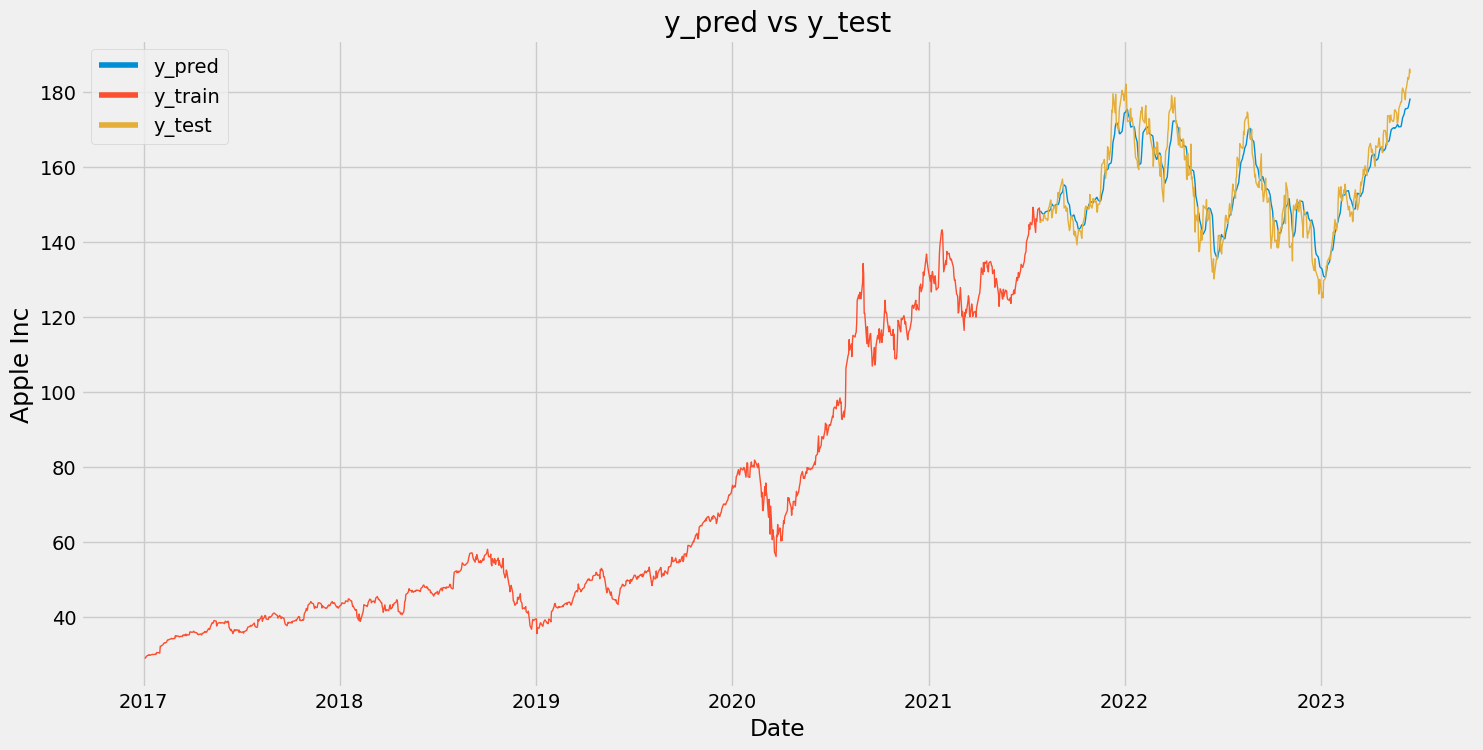

In [ ]:
# The date from which on the date is displayed
display_start_date = "2017-01-01"

# Add the difference between the valid and predicted prices
train = pd.DataFrame(df3['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(df3['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
#sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

## Predict the Next Day’s Price

In [ ]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
last_price = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
percent_change = np.round(100 - (last_price * 100)/predicted_price, 2)

print('Last price was:', last_price)
print('predicted_price for next day is : ', predicted_price)
print('percent_change is : ', percent_change)


1/1 [==============================] - 0s 62ms/step
Last price was: 184.92
predicted_price for next day is :  178.81
percent_change is :  -3.42
